## Setup Simulation

Import needed libraries and define constants

In [1]:
# Set plotting in separate window
#%matplotlib qt
# Imports
from rcfdtd_sim import Sim, Current, Mat, vis
import numpy as np
from scipy.fftpack import fft, fftfreq
from matplotlib import pyplot as plt
from pathlib import Path
# Constants
c0 = 1 # um/ps
di = 0.003 # 0.003 um
dn = di/c0 # (0.003 um) / (300 um/ps) = 0.00001 ps = 0.01 fs
epsilon0 = 1
mu0 = 1

Define simulation bounds and calculate length in indicies

In [2]:
# Define bounds
i0 = -5 # -5 um
i1 = 5 # 5 um
n0 = -90 # (0.01 fs) * (-90 um) / (0.003 um/step) = (0.01 fs) * (-30,000 steps) = -300 fs
n1 = 210 # (0.01 fs) * (210 um) / (0.003 um/step) = (0.01 fs) * (70,000 steps) = 700 fs
# Calculate dimensions
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)

In [3]:
print(nlen, ilen)

100000 3335


Create our time and space arrays to help construct our material and current pulse

In [4]:
# Create a arrays that hold the value of the center of each cell
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False) * (10/3) # Multiply by 10/3 to get from um -> fs
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)

## Setup Material

Specify the location of our material (which will be $0.09$um in length)

In [5]:
# Set material length
m_len = 0.09 # 0.09 um
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len

Calculate the starting and ending indicies of our material

In [6]:
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))

Setup material behavior

In [7]:
# Set constants
a = np.complex64(1)
gamma = np.complex64(0.01)
freq = np.complex64(1)
# Calculate beta
ang_gamma = np.complex64(gamma * 2 * np.pi)
omega = np.complex64(freq * 2 * np.pi)
beta = np.sqrt(np.add(np.square(ang_gamma), -np.square(omega)), dtype=np.complex64)
a1 = np.complex64(a/(2*beta))
a2 = np.complex64(-a/(2*beta))

In [8]:
print(gamma, beta, a1, a2)

(0.01+0j) 6.2828712j -0.07958145j (-0+0.07958145j)


Create our material behavior matrices

In [9]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * ang_gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

Create our material object

In [10]:
inf_perm = 16
material = Mat(dn, ilen, nlen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta, storelocs=[1])

## Specifying Currents

Specify the location of our current pulses in time and space

In [11]:
cp_loc_val = -3 # -3 um
cp_time_val = 0 # 0 fs

Determine the simulation indicies that correspond to these locations

In [12]:
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
spread = int(250 / 0.01) # (250 fs) / (0.01 fs/step) = 25,000 steps
cp_time_s = cp_time_ind - spread
cp_time_e = cp_time_ind + spread

Make a list to hold our current pulses and lists to hold current pulse widths. We will only examine the second derivative of the Gaussian, the Lorentzian, and the first two derivatives of the Lorentzian here, as they are appeared most promising in the previous study.

In [13]:
current_list_names = ['dd_gauss', 'loren', 'd_loren', 'dd_loren']
current_list = []
gauss_widths = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 6e1, 6e2, 6e3, 6e4]
loren_widths = [1e-2, 1e-1, 1e0, 1e1, 20, 40, 60, 80, 100, 120]

Create the second derivative of the Gaussian current pulse

In [14]:
# Make pulse defining program
def gen_current(width):
    carray = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(width)))), [0,0])
    current = Current(nlen, ilen, cp_time_s, cp_loc_ind, carray)
    return current
# Add definition to list
current_list.append(gen_current)

Create the Lorentzian current pulse

In [15]:
# Make pulse defining program
def gen_current(width):
    carray = np.divide(0.5*width, np.pi*np.add(np.square(t[cp_time_s:cp_time_e] - cp_time_val), np.square(0.5*width)))
    current = Current(nlen, ilen, cp_time_s, cp_loc_ind, carray)
    return current
# Add definition to list
current_list.append(gen_current)

Create the first derivative of the Lorentzian current pulse

In [16]:
# Make pulse defining program
def gen_current(width):
    carray = np.append(np.diff(np.divide(0.5*width, np.pi*np.add(np.square(t[cp_time_s:cp_time_e] - cp_time_val), np.square(0.5*width)))), [0])
    current = Current(nlen, ilen, cp_time_s, cp_loc_ind, carray)
    return current
# Add definition to list
current_list.append(gen_current)

Create the second derivative of the Lorentzian current pulse

In [17]:
# Make pulse defining program
def gen_current(width):
    carray = np.append(np.diff(np.diff(np.divide(0.5*width, np.pi*np.add(np.square(t[cp_time_s:cp_time_e] - cp_time_val), np.square(0.5*width))))), [0,0])
    current = Current(nlen, ilen, cp_time_s, cp_loc_ind, carray)
    return current
# Add definition to list
current_list.append(gen_current)

## Running the Simulations

Create and run a simulation for each current (or load simulation result if one already exists)

In [18]:
# Define a function to run the simulation if no simulation file currently exists
def run_sim(sfname, i, width):
    # Extract current function
    current = current_list[i]
    # Only proceed if simulation doesn't exist
    sim_file = Path(sfname)
    if not sim_file.is_file():
        print('Starting simulation ' + fname)
        # Create simulation object, calling the current function
        s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current(width), material, nstore=int(nlen/80), storelocs=[5,ilen-6])
        # Run simulation
        s.simulate()
        # Save results
        n, ls, els, erls, hls, hrls = s.export_locs()
        ls_mat, chi = material.export_locs()
        n = n * (10/3) # 10/3 scale factor converts from um -> fs
        np.savez(sfname, n=n, ls=ls, els=els, erls=erls, hls=hls, hrls=hrls, chi=chi)
    else:
        print('Loading simulation ' + fname)
        

# Save a list of the simulation file names for later use
sim_names = []
        
# Loop through all current shapes
for i in range(len(current_list)):
    # Loop through all current shape widths, depending if Gaussian
    if i == 0:
        # Gaussian, loop Gaussian widths
        for width in gauss_widths:
            fname = 's2_' + current_list_names[i] + '_' + str(width) + '.npz'
            sim_names.append(fname)
            run_sim(fname, i, width)
    else:
        # Loop through all current shape widths
        for width in loren_widths:
        # Lorentzian, loop Lorentzian widths
            fname = 's2_' + current_list_names[i] + '_' + str(width) + '.npz'
            sim_names.append(fname)
            run_sim(fname, i, width)

Loading simulation s2_dd_gauss_0.001.npz
Loading simulation s2_dd_gauss_0.01.npz
Loading simulation s2_dd_gauss_0.1.npz
Loading simulation s2_dd_gauss_1.0.npz
Loading simulation s2_dd_gauss_10.0.npz
Loading simulation s2_dd_gauss_60.0.npz
Loading simulation s2_dd_gauss_600.0.npz
Loading simulation s2_dd_gauss_6000.0.npz
Loading simulation s2_dd_gauss_60000.0.npz
Loading simulation s2_loren_0.01.npz
Loading simulation s2_loren_0.1.npz
Loading simulation s2_loren_1.0.npz
Loading simulation s2_loren_10.0.npz
Loading simulation s2_loren_20.npz
Loading simulation s2_loren_40.npz
Loading simulation s2_loren_60.npz
Loading simulation s2_loren_80.npz
Loading simulation s2_loren_100.npz
Loading simulation s2_loren_120.npz
Loading simulation s2_d_loren_0.01.npz
Loading simulation s2_d_loren_0.1.npz
Loading simulation s2_d_loren_1.0.npz
Loading simulation s2_d_loren_10.0.npz
Loading simulation s2_d_loren_20.npz
Loading simulation s2_d_loren_40.npz
Loading simulation s2_d_loren_60.npz
Loading simu

## Displaying simulation results

We create a function to calculate $E_i(t)$, $E_t(t)$, and $E_r(t)$.

In [19]:
def calc_fields(els, erls):
    # Extract the reference E-field passing through i=ilen-6 as the incident field
    inc = erls[:,1]
    # Extract the E-field passing through i=ilen-6 as the transmitted field
    trans = els[:,1]
    # Extract the E-field passing through i=5 and the reference E-field passing through i=5 to calculate the reflected field
    r = els[:,0] # Extract the transmitted E-field
    rref = erls[:,0]
    refl = r - rref
    # Return inc, trans, refl
    return (inc, trans, refl)

Create a function to calculate the $E_i(\omega)$, $E_t(\omega)$, and $E_r(\omega)$, that is the Fourier transforms of $E_i(t)$, $E_t(t)$, and $E_r(t)$.

In [20]:
def calc_transforms(nlen, dn, inc, trans, refl):
    # Determine the frequency axis
    nf = fftfreq(nlen, dn) * 1e4 #  # Mulitply by 1e4 to go from units of 1e16 Hz -> 1e14 Hz which is THz
    # Perform FFT on each field
    incf = fft(inc)
    transf = fft(trans)
    reflf = fft(refl)
    # Discard negative frequencies (at nlen/2 and above) and keep DC (at 0) for each field
    nf = nf[0:int(nlen/2)]
    incf = incf[0:int(nlen/2)]
    transf = transf[0:int(nlen/2)]
    reflf = reflf[0:int(nlen/2)]
    # Return nf, incf, transf, and reflf
    return (nf, incf, transf, reflf)

Generate plots for each current simulation

In [21]:
print(sim_names[8])

s2_dd_gauss_60000.0.npz


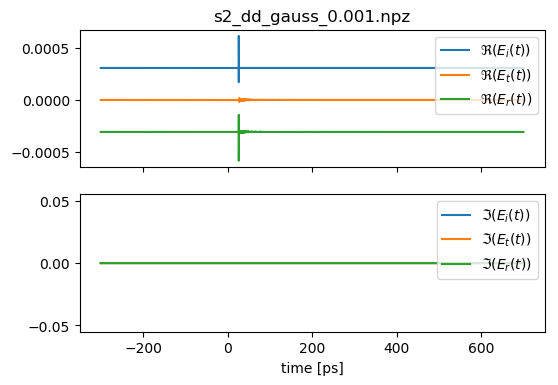

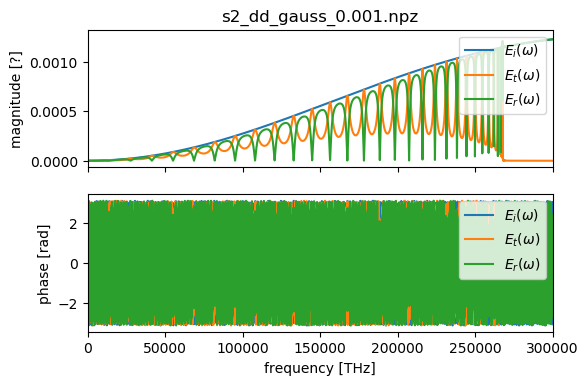

/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide


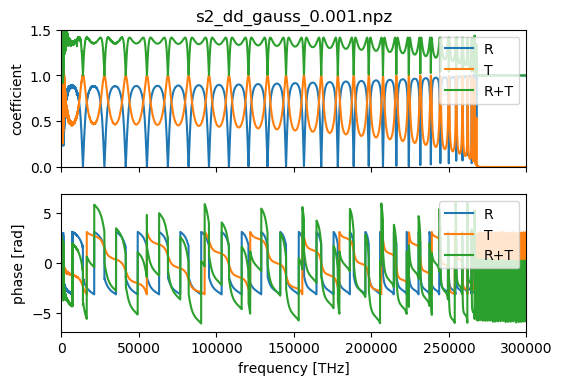

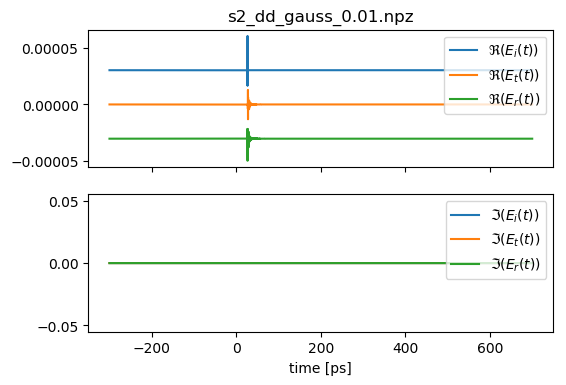

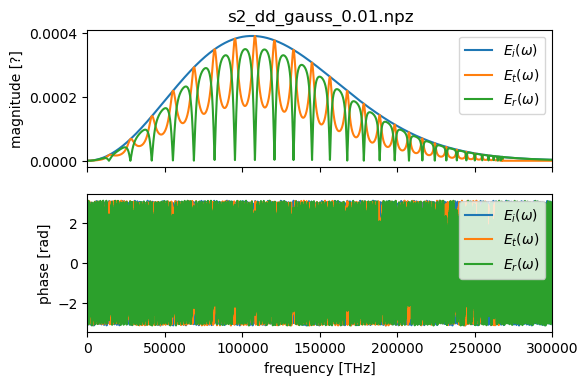

/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


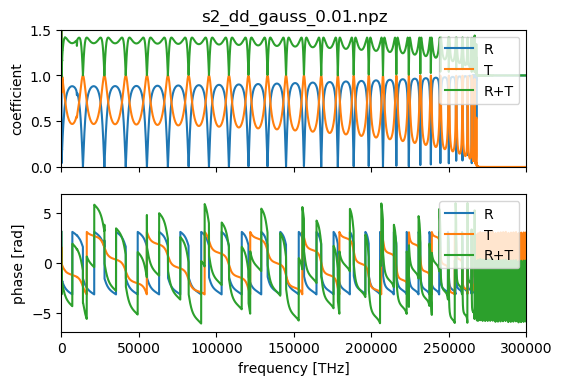

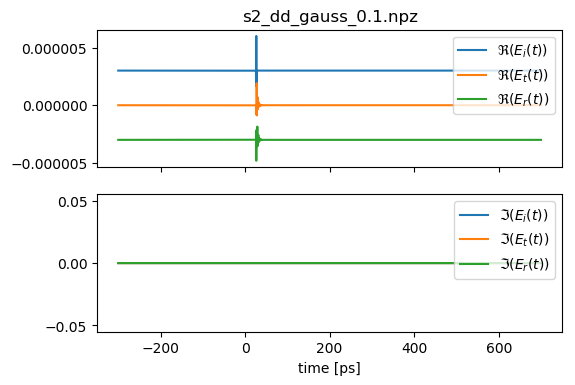

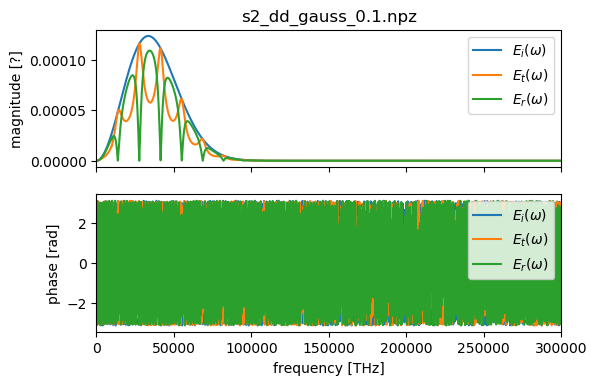

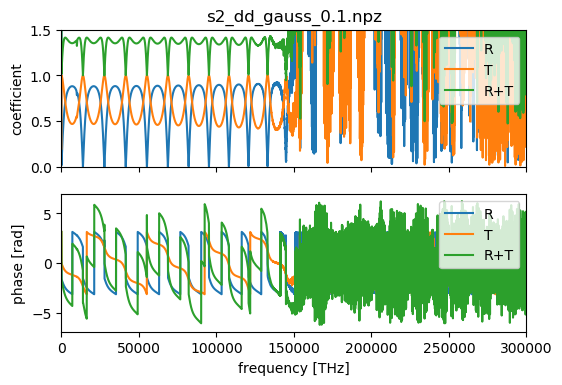

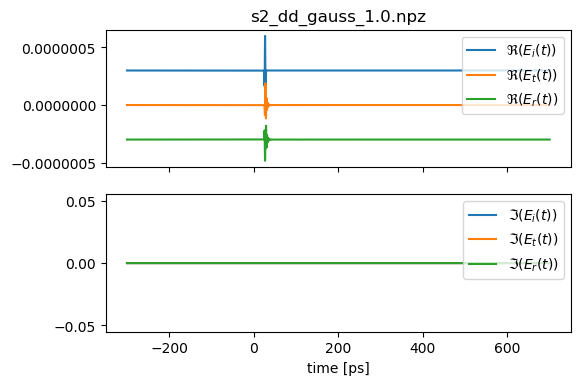

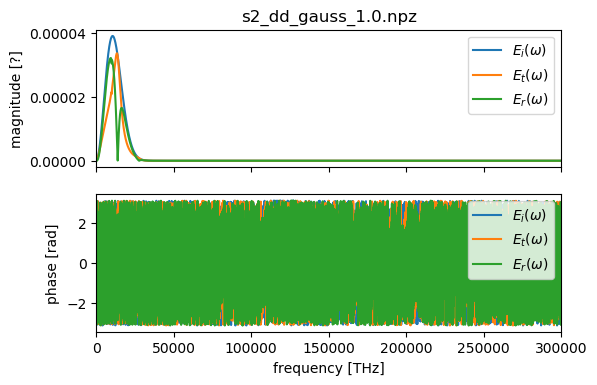

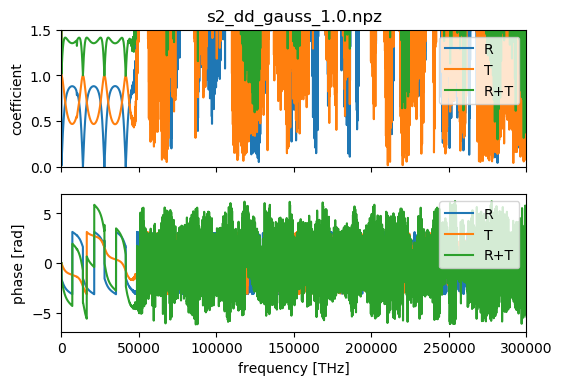

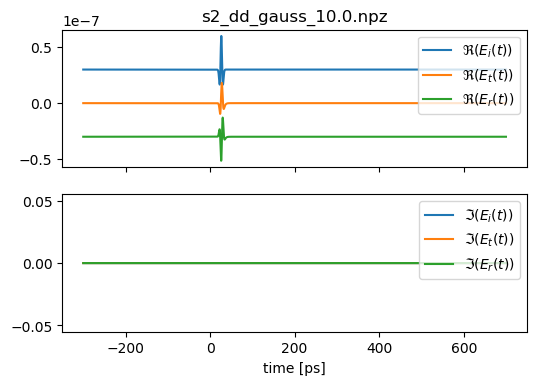

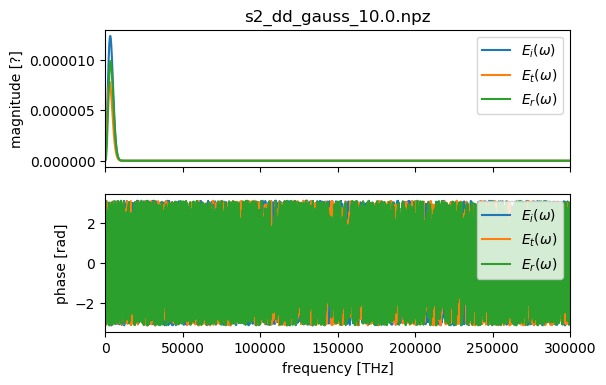

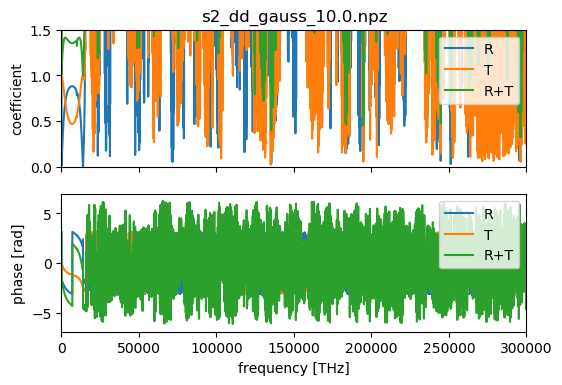

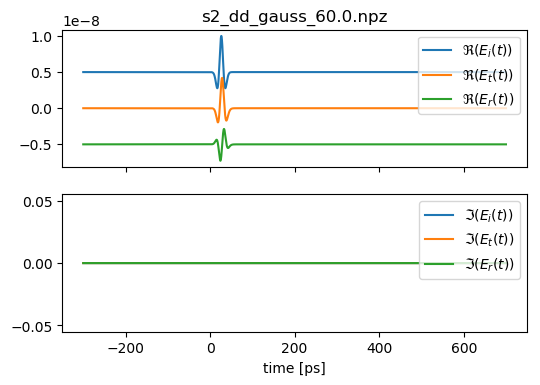

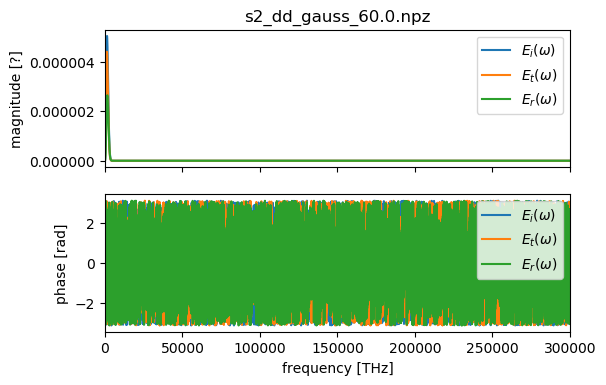

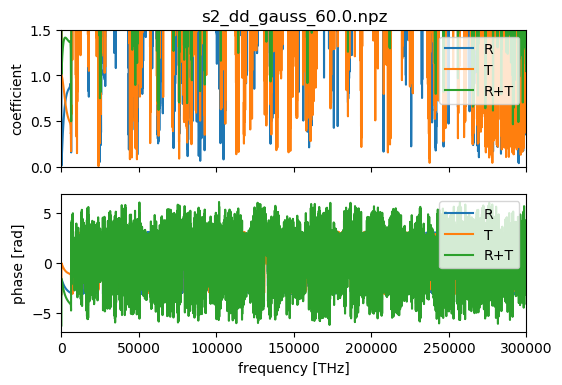

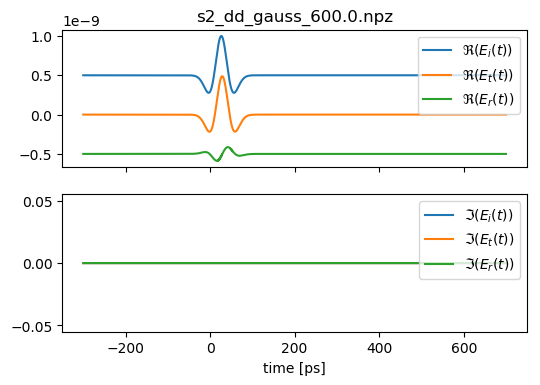

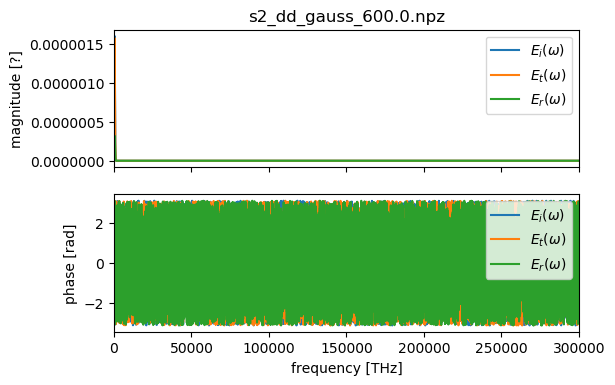

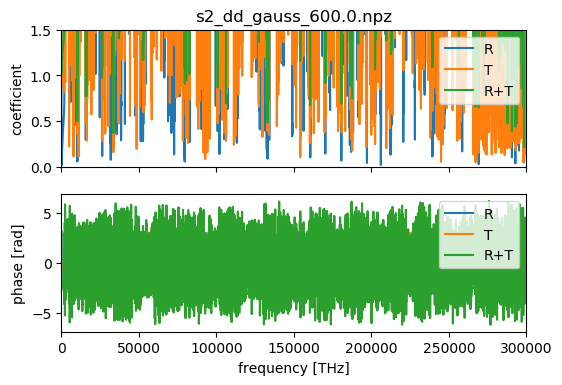

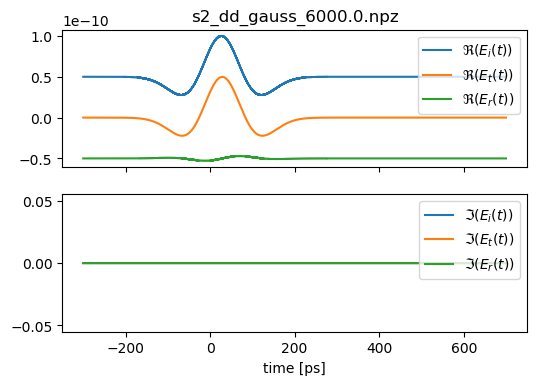

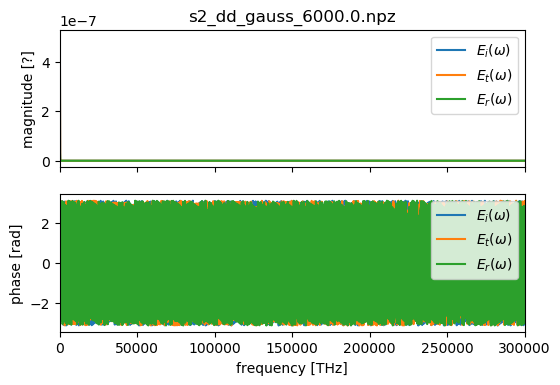

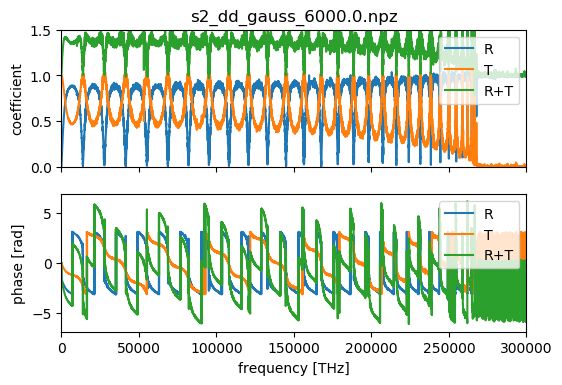

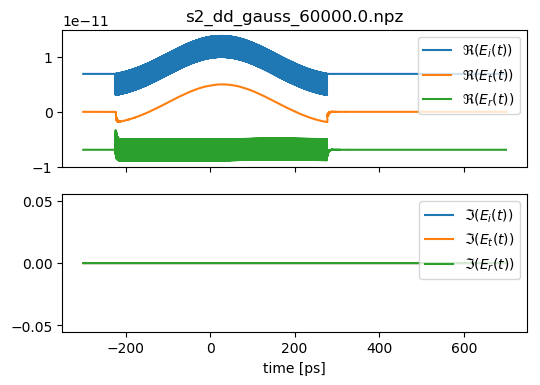

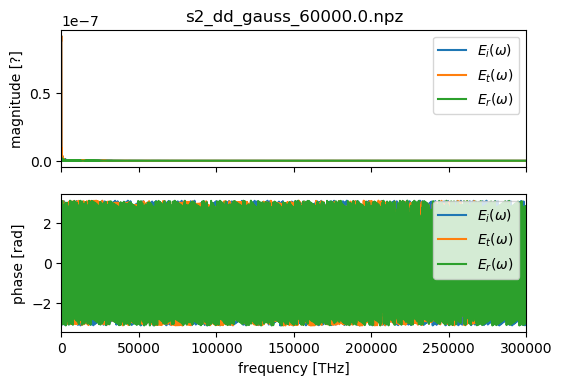

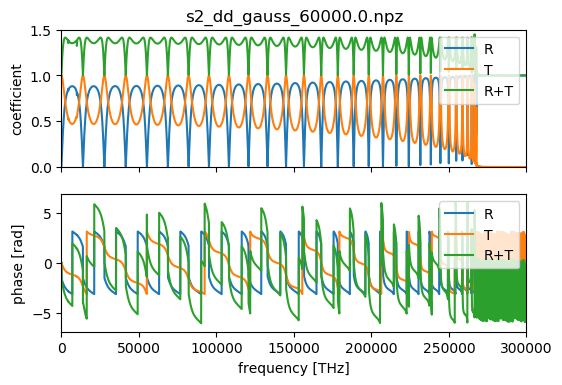

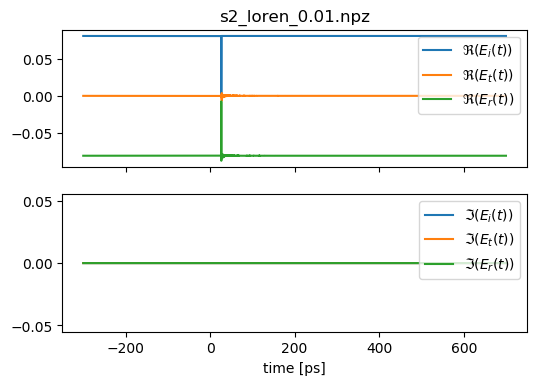

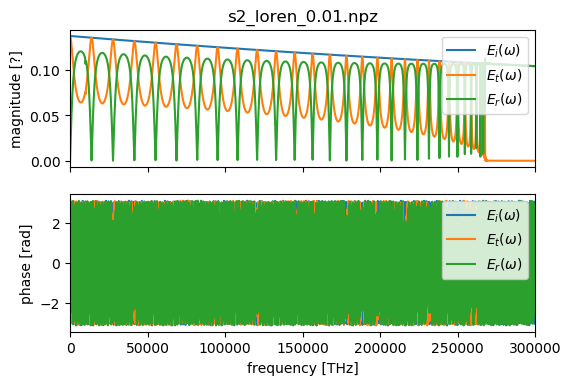

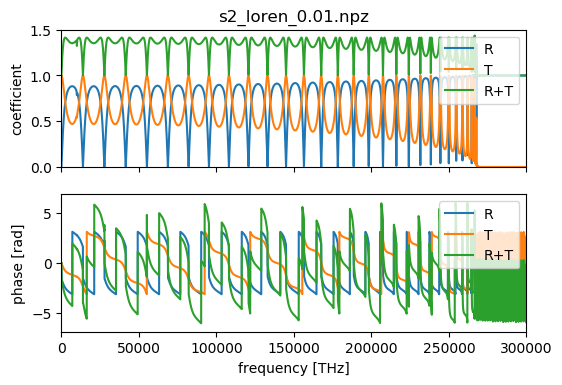

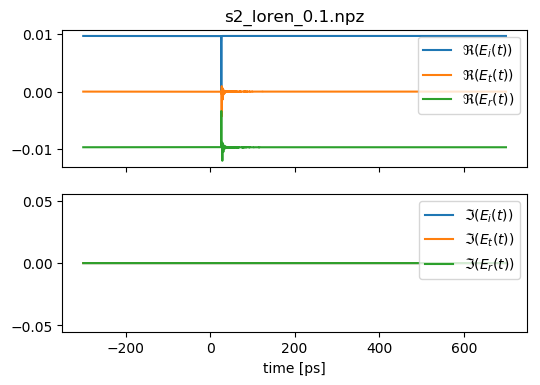

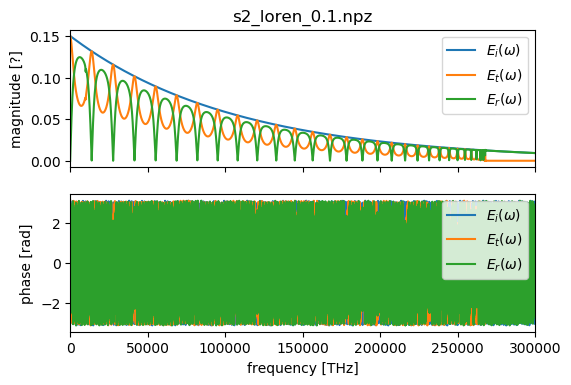

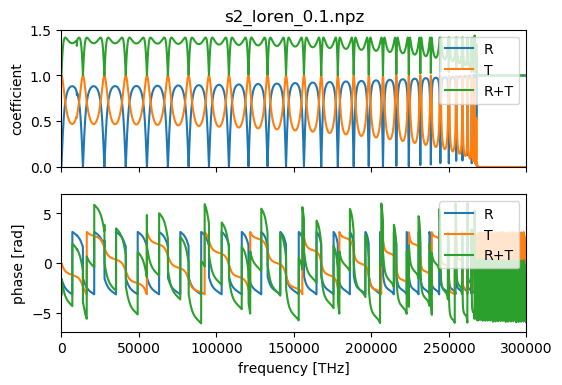

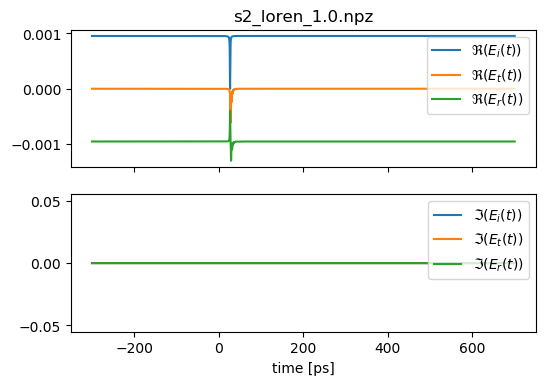

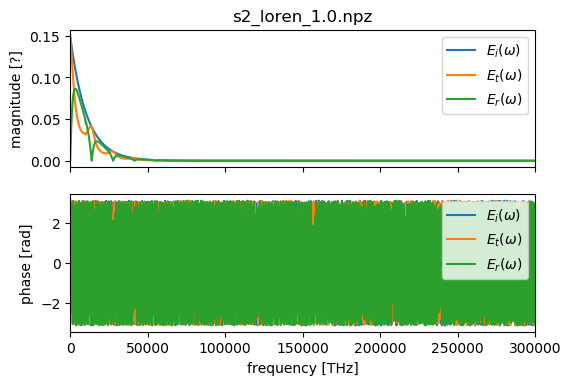

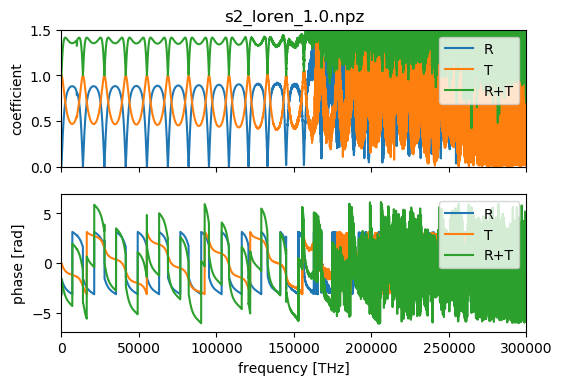

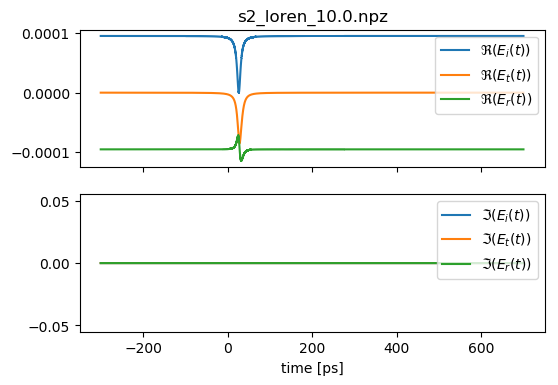

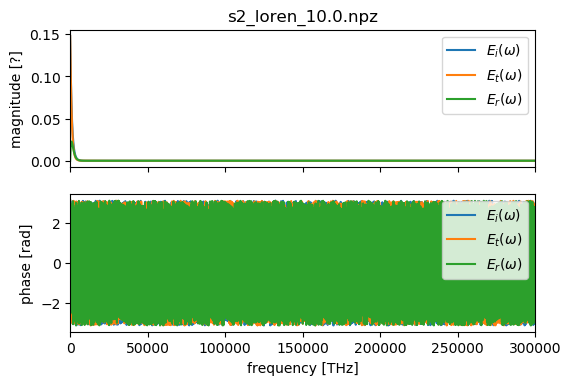

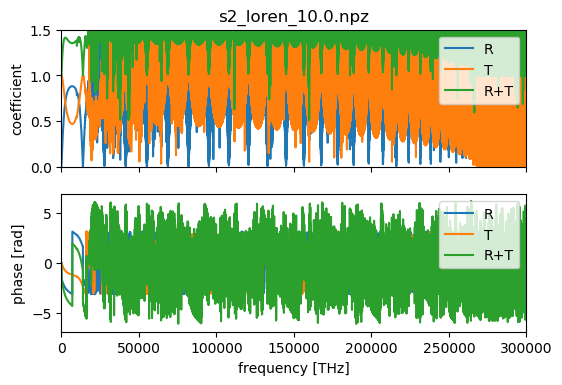

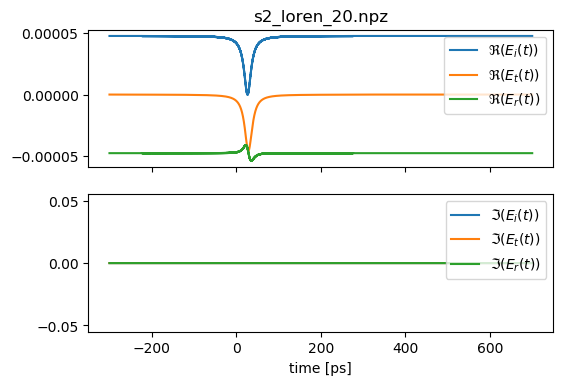

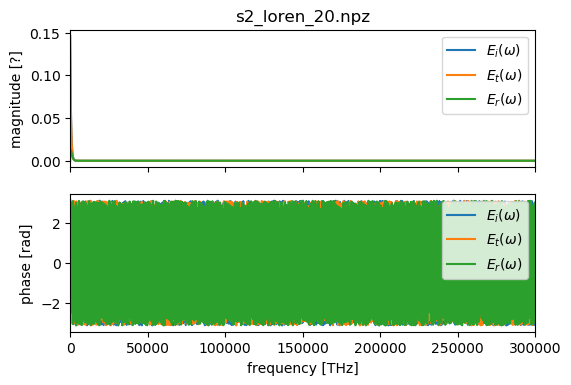

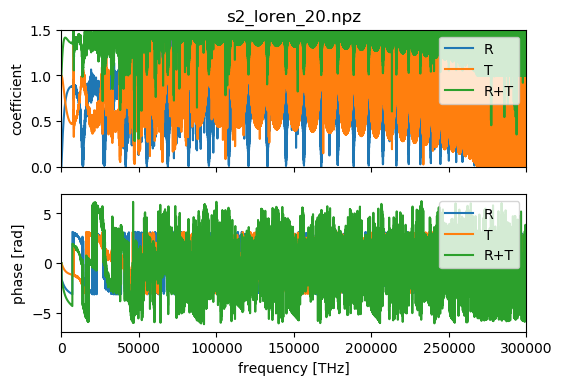

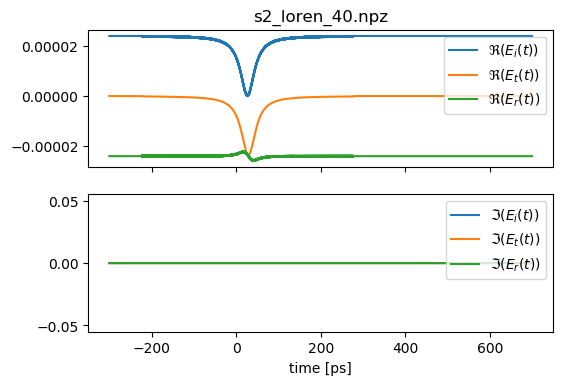

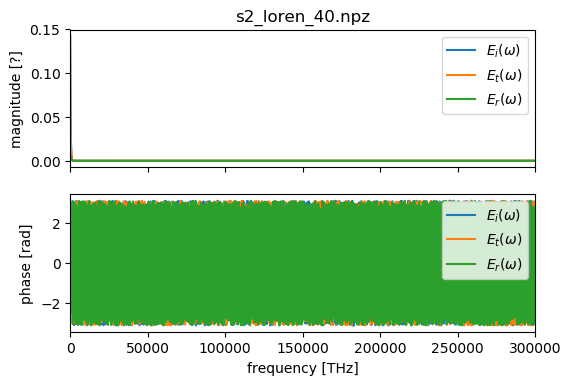

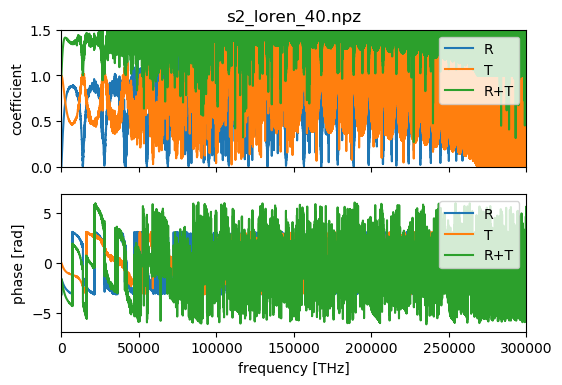

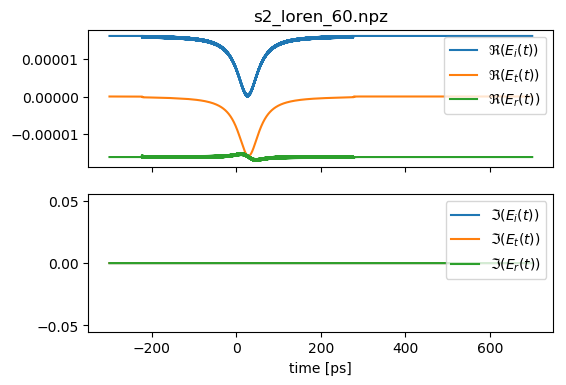

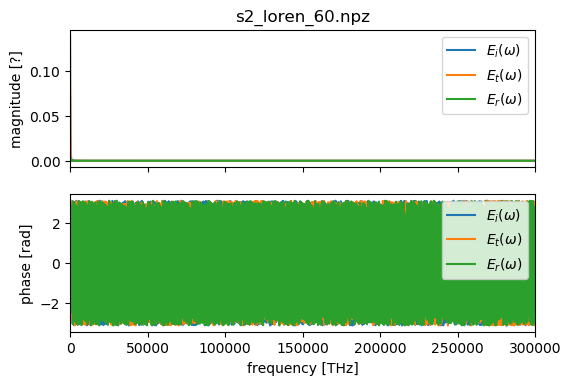

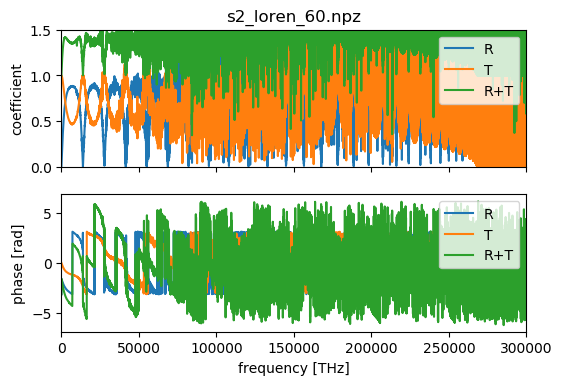

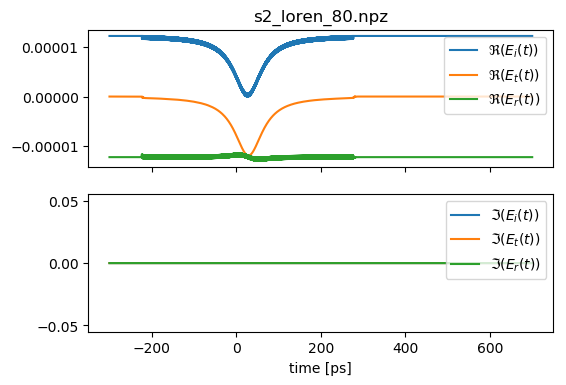

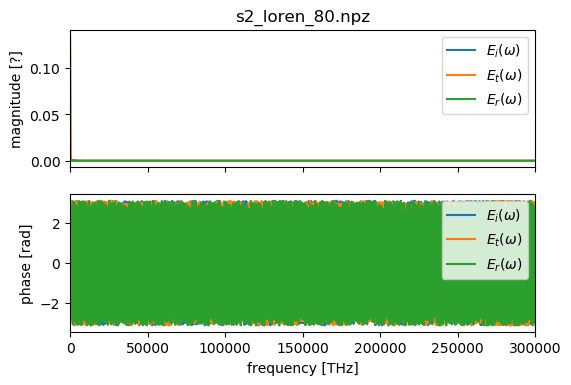

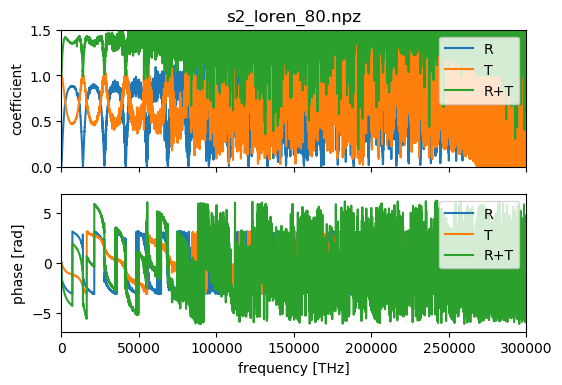

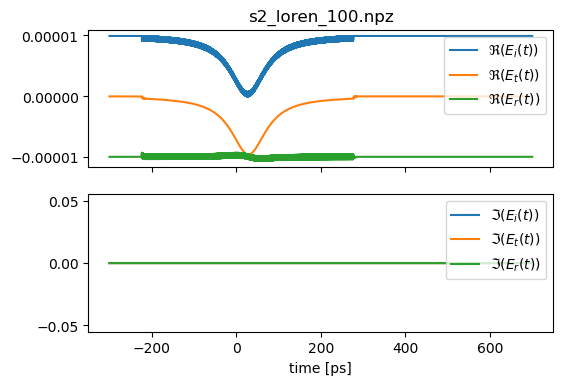

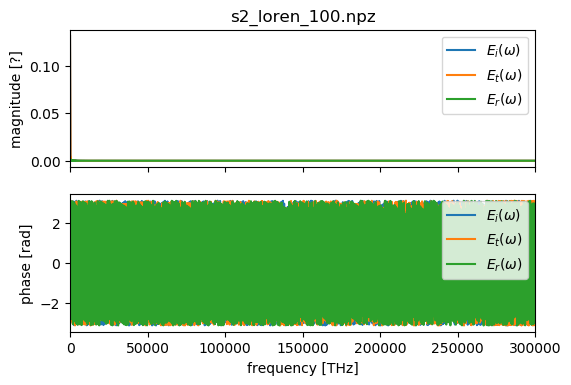

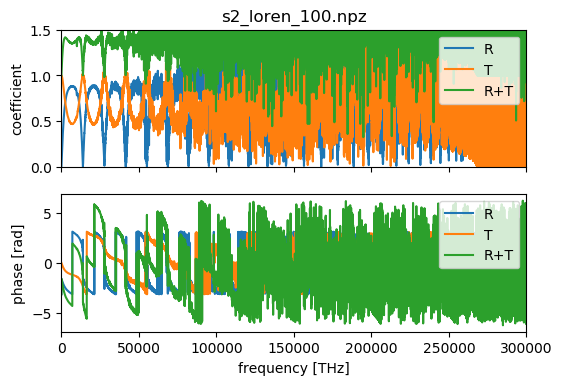

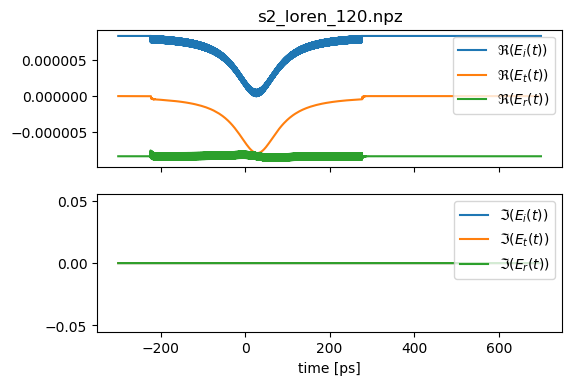

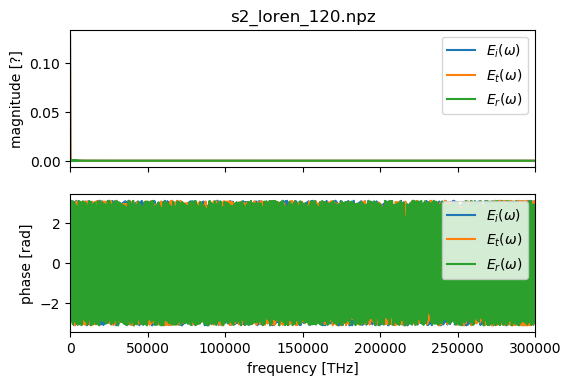

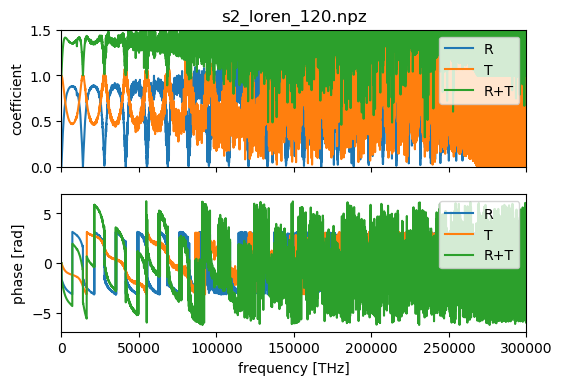

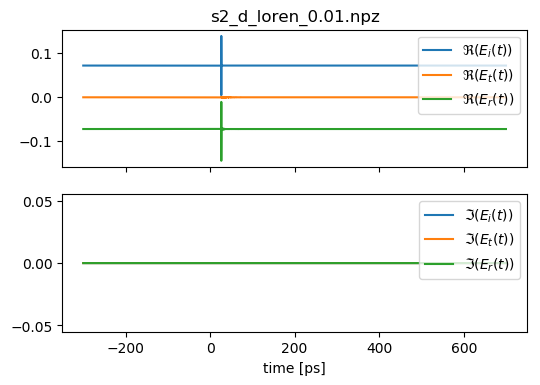

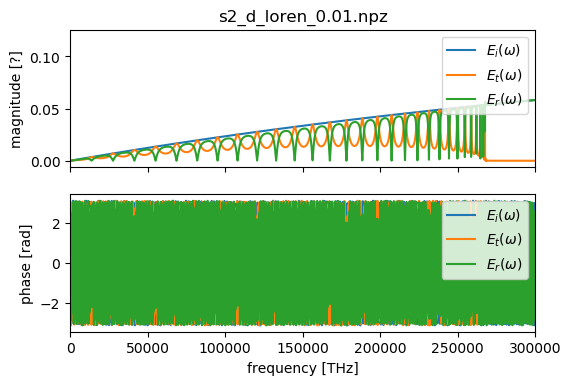

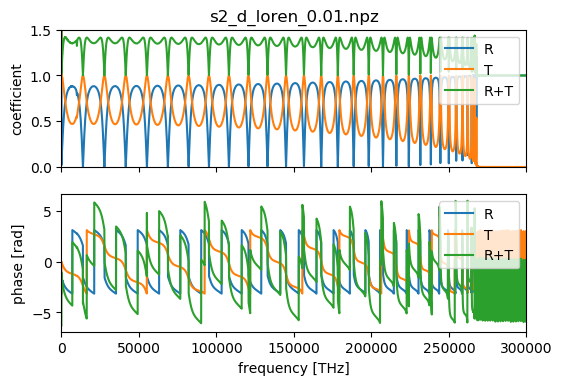

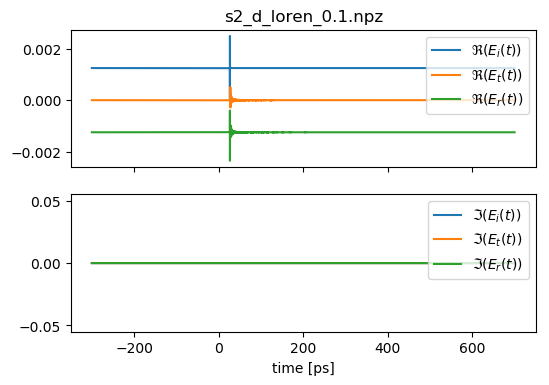

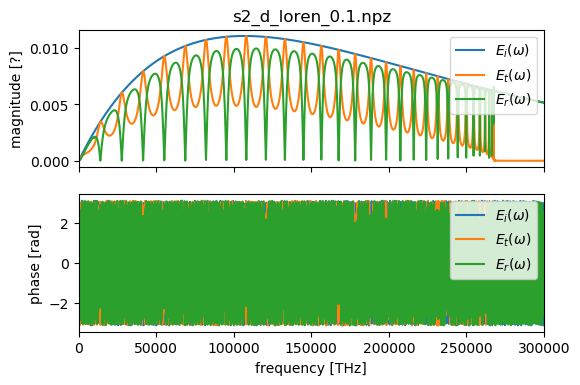

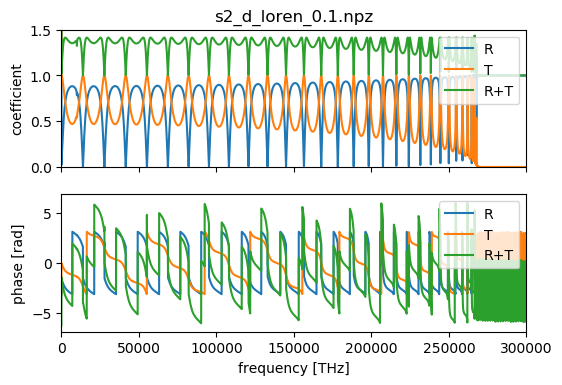

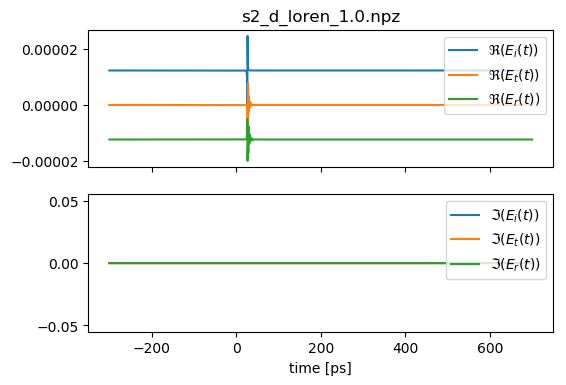

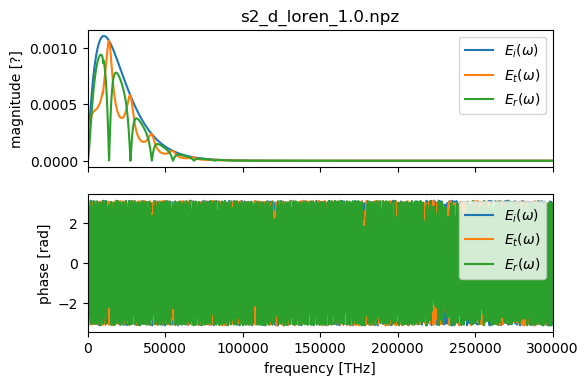

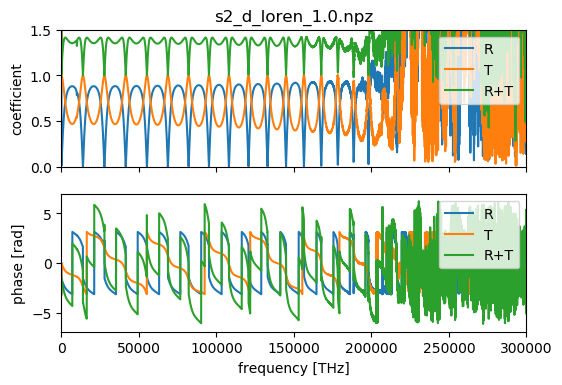

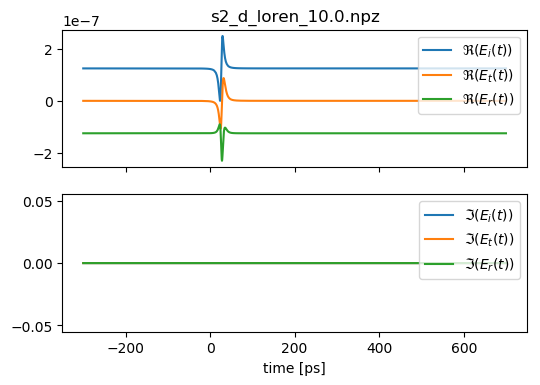

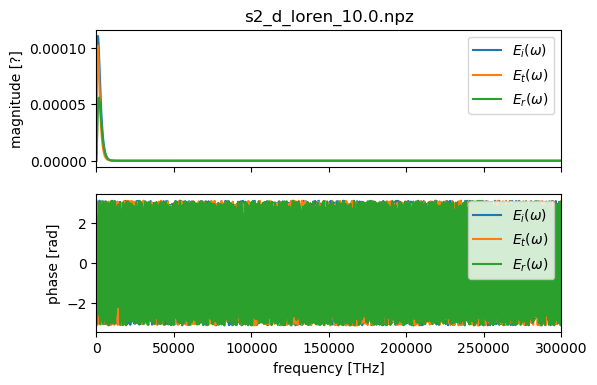

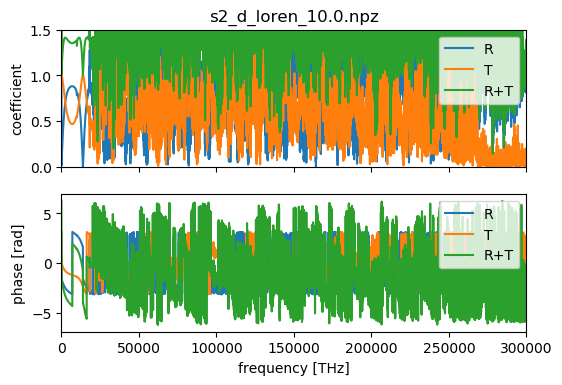

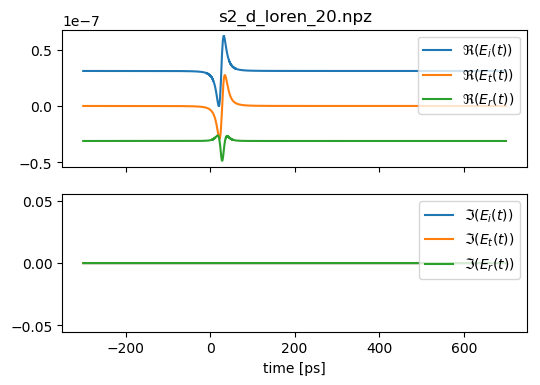

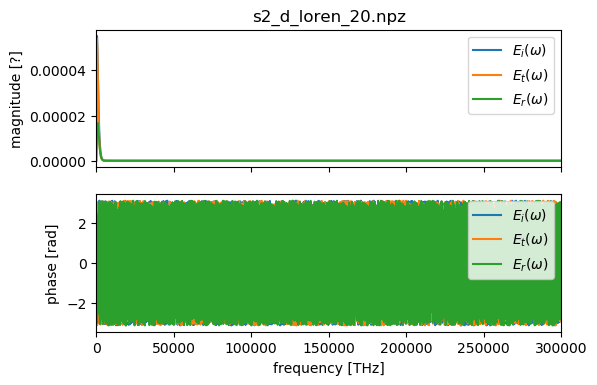

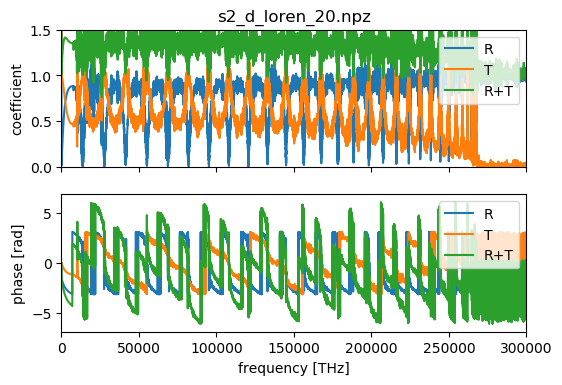

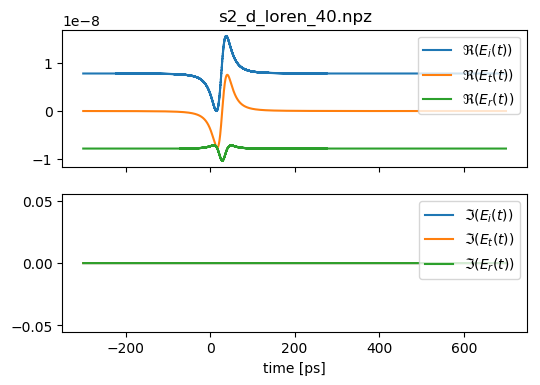

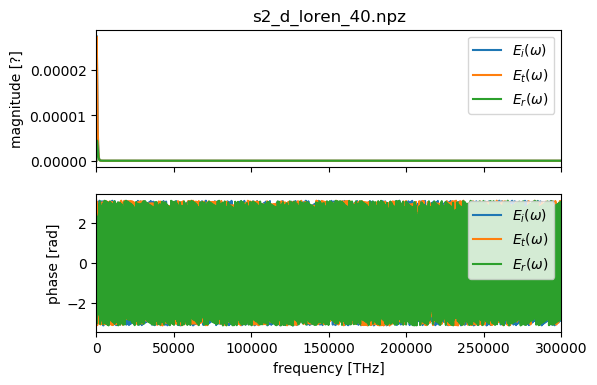

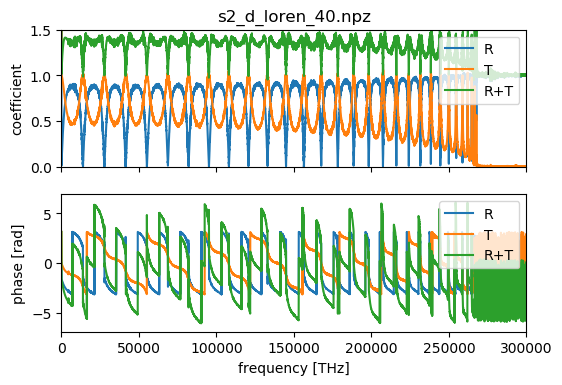

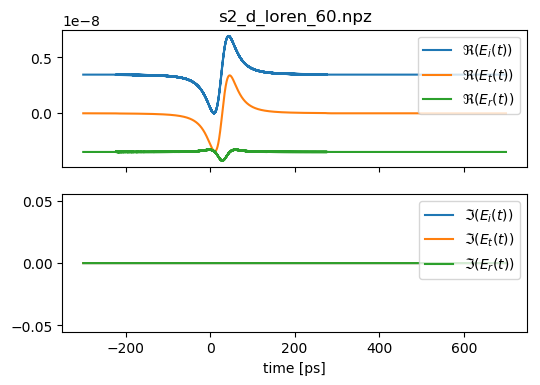

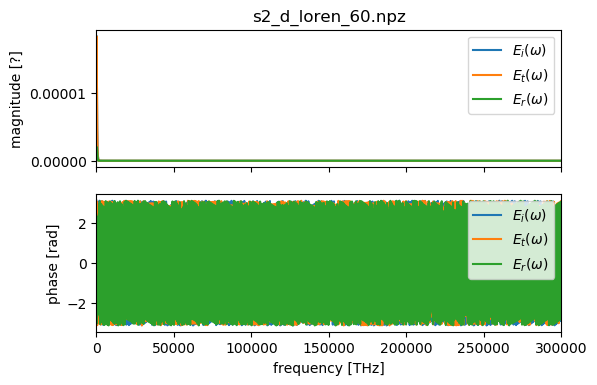

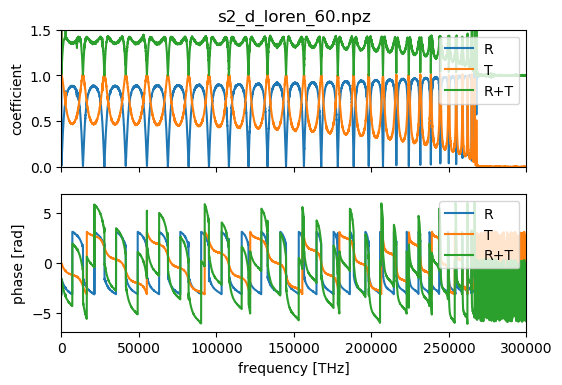

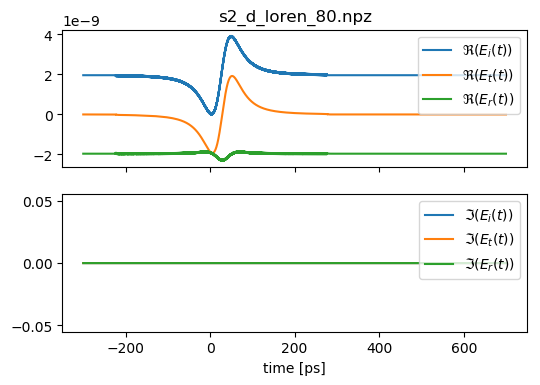

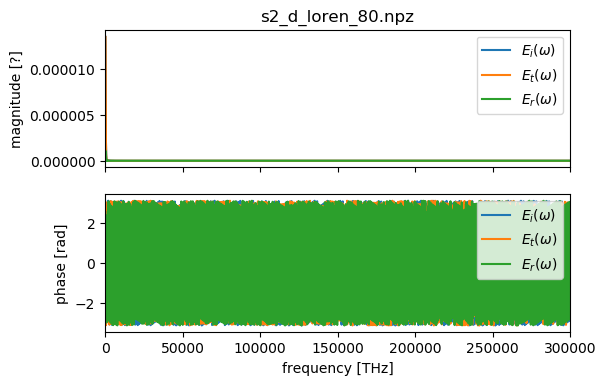

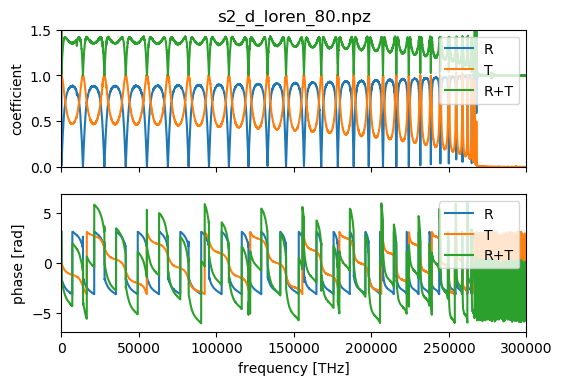

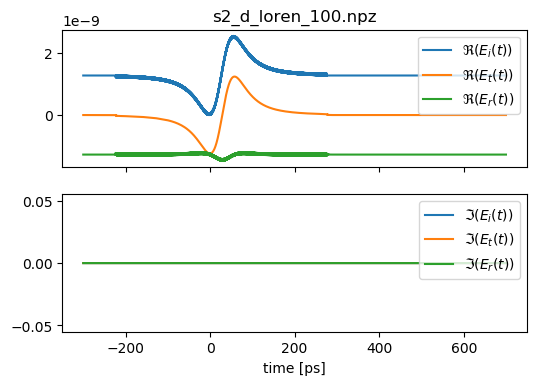

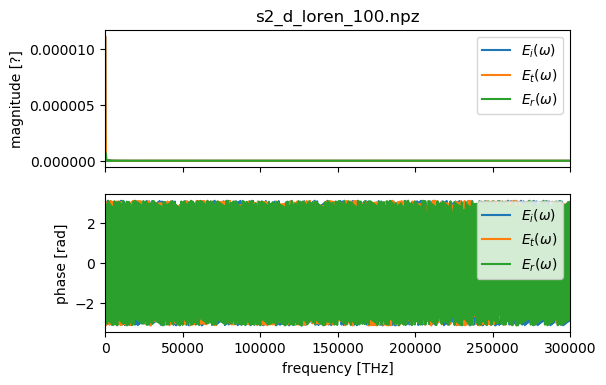

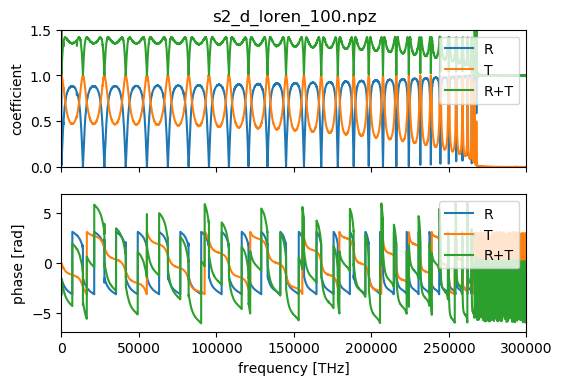

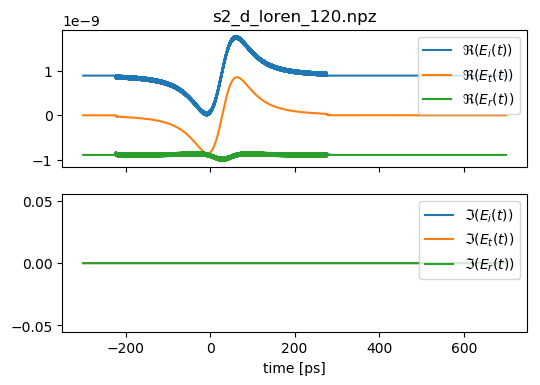

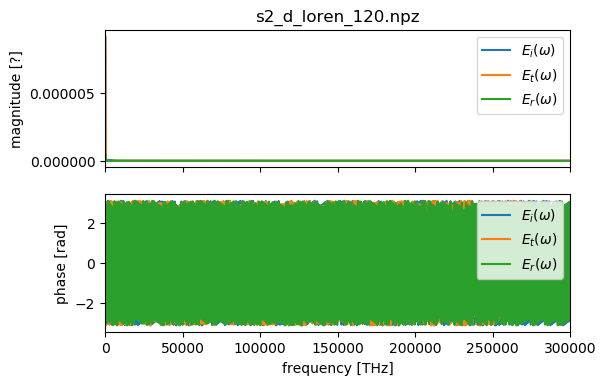

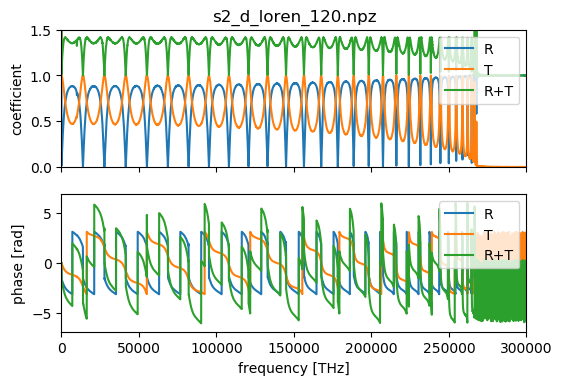

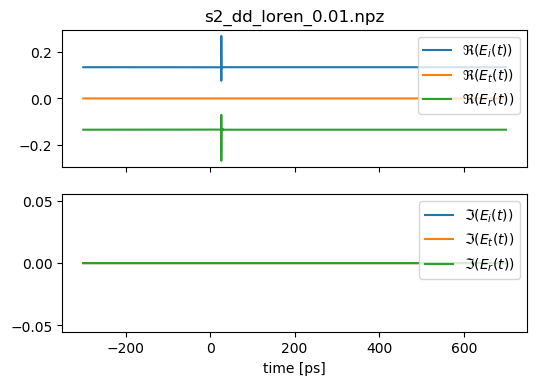

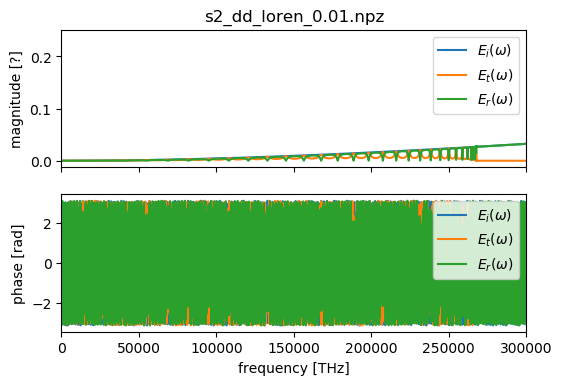

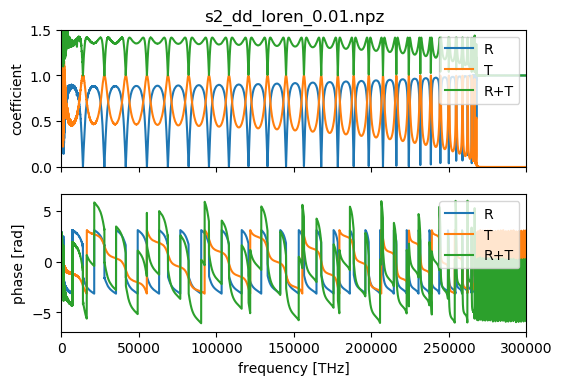

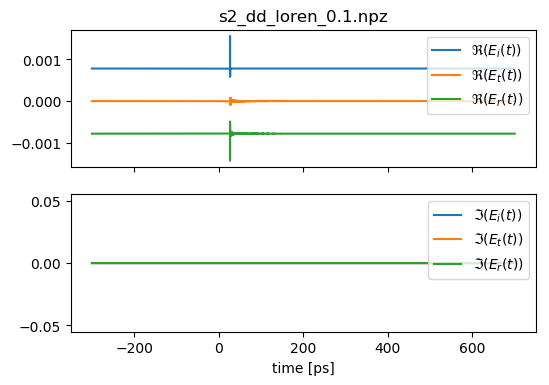

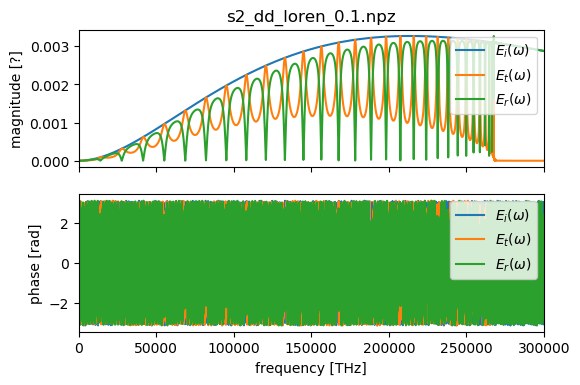

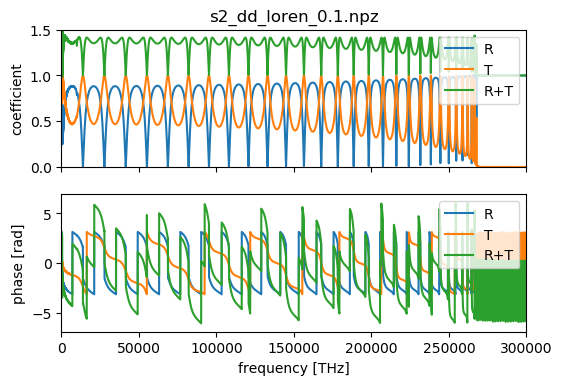

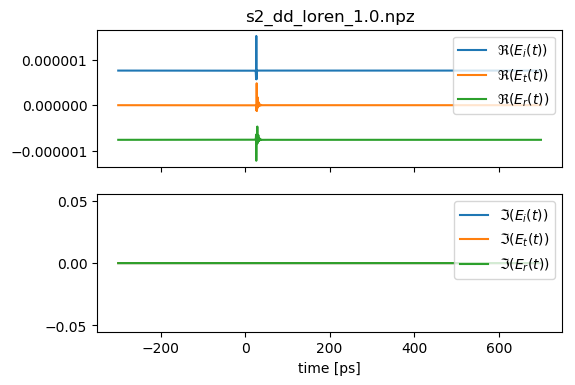

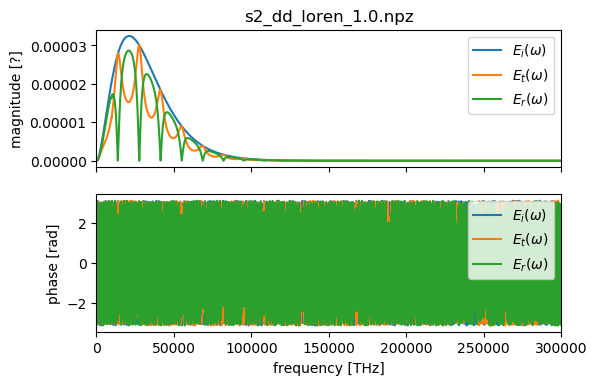

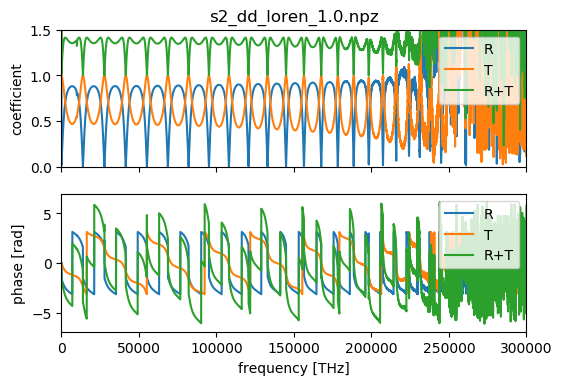

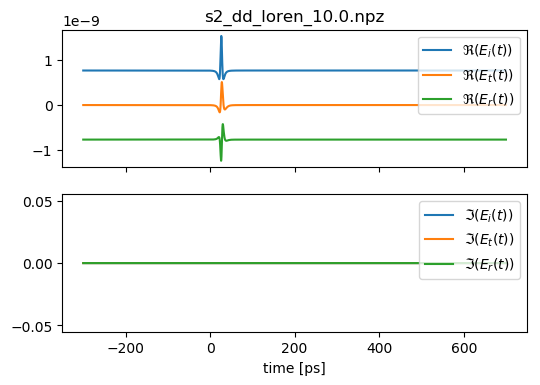

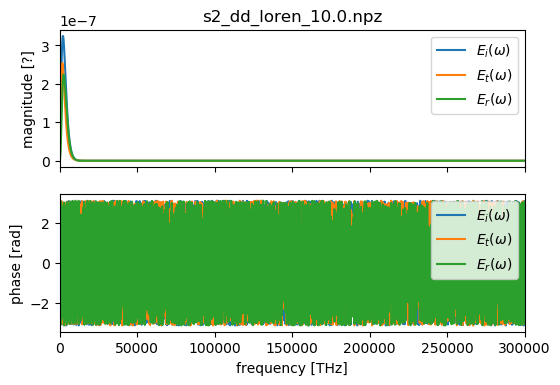

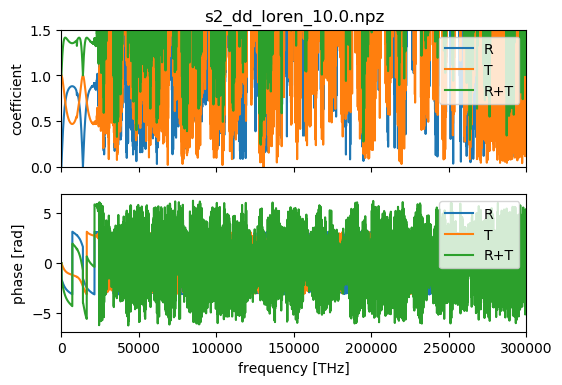

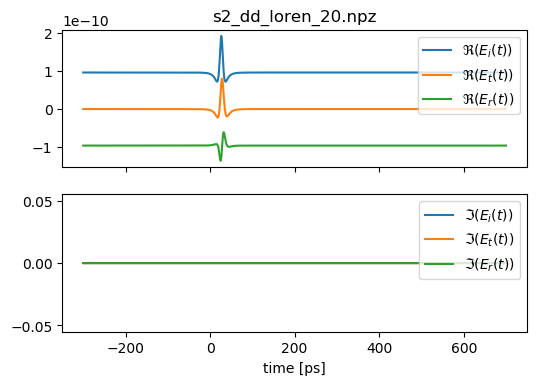

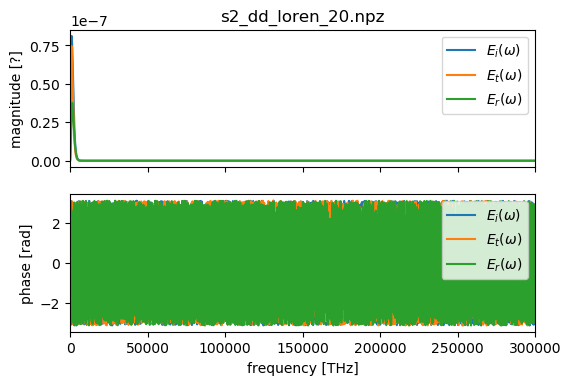

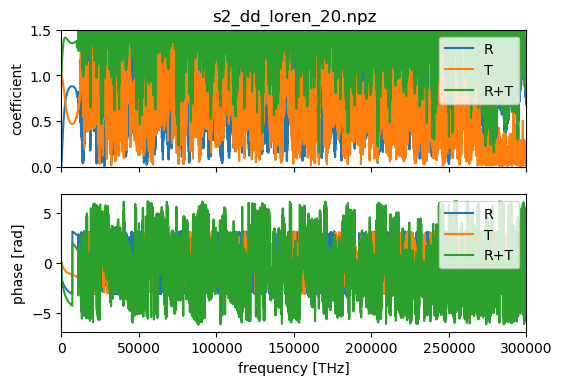

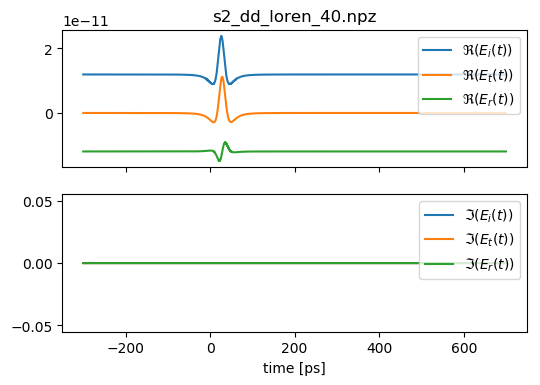

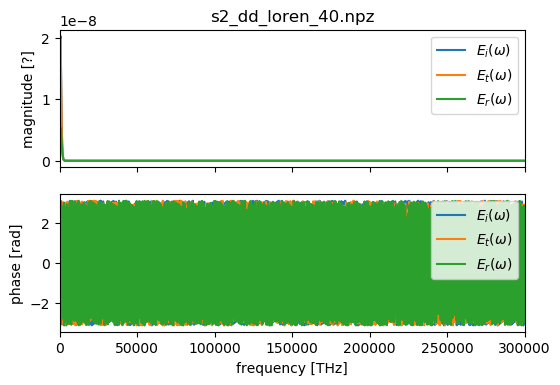

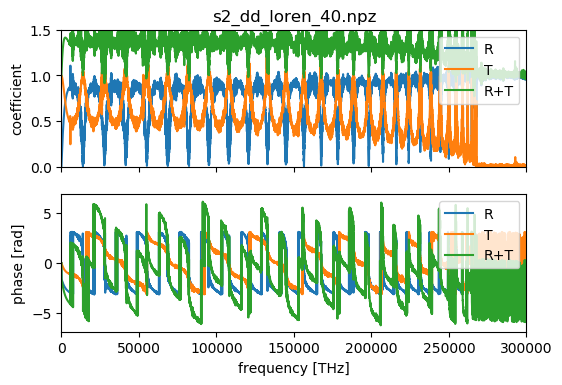

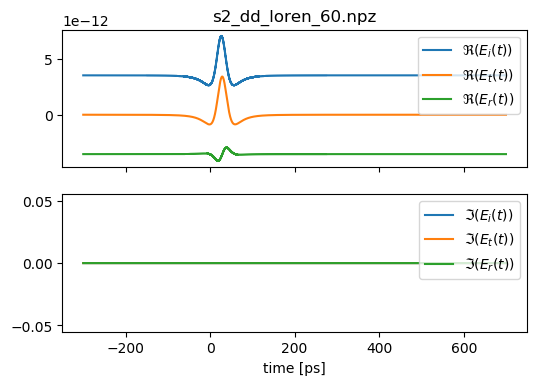

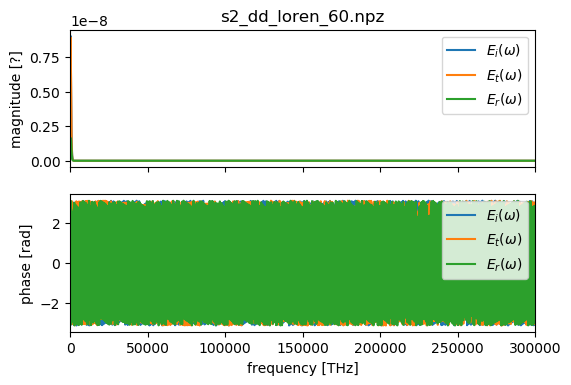

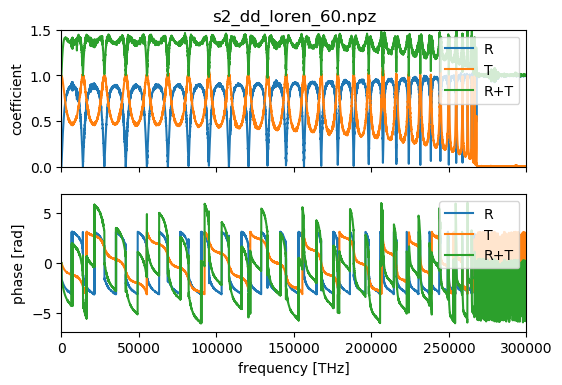

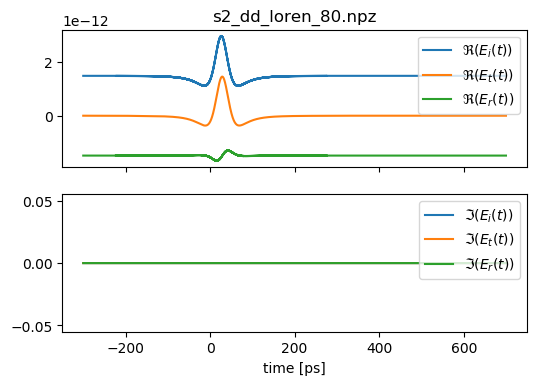

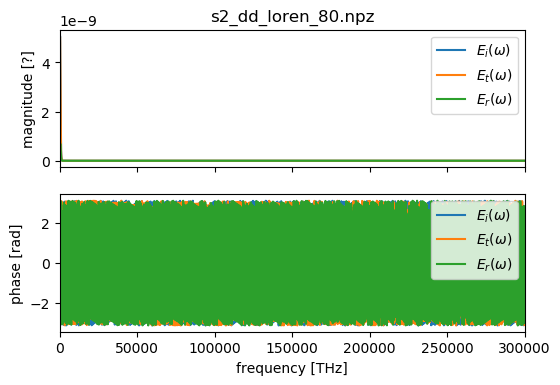

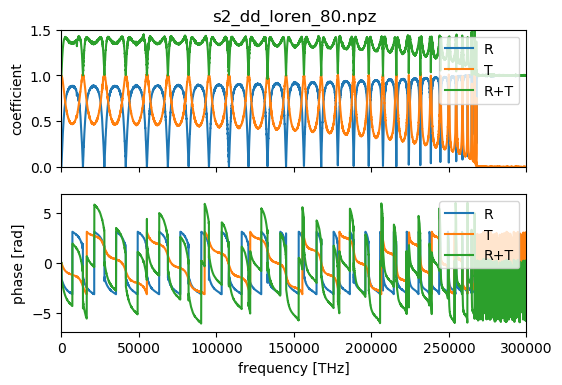

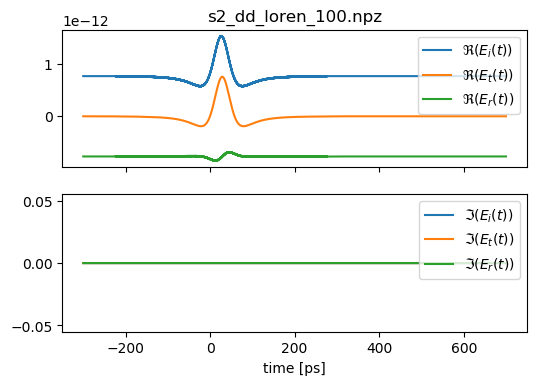

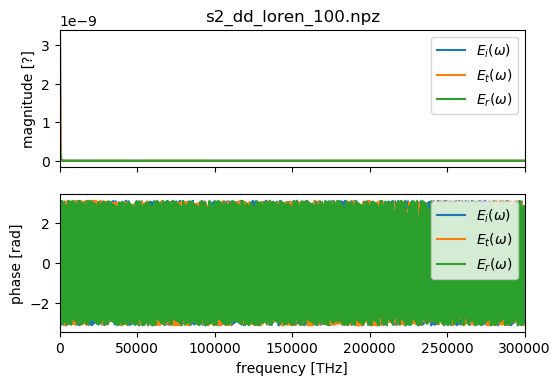

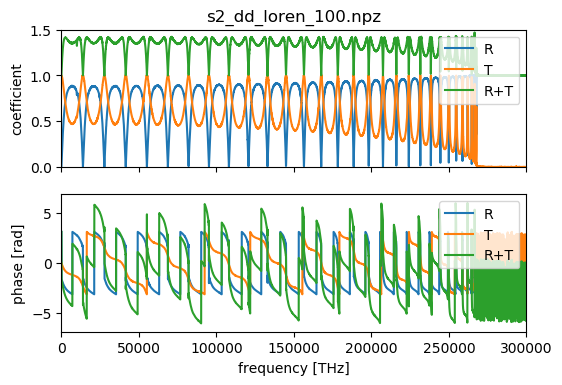

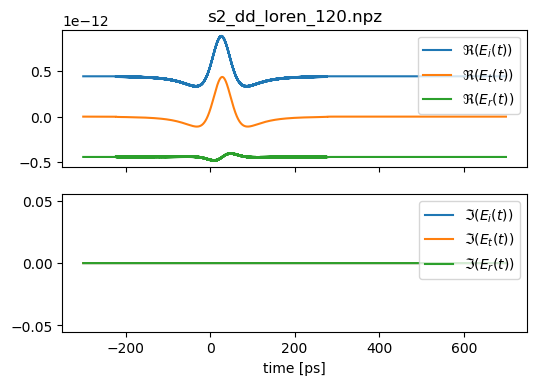

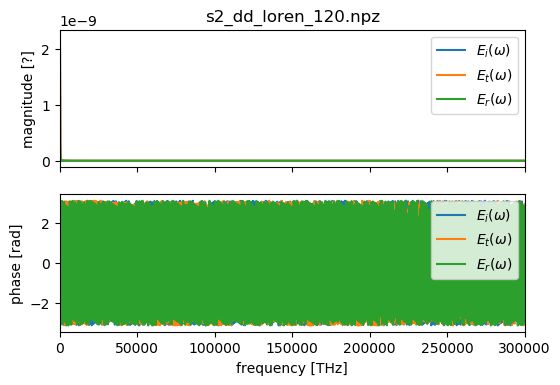

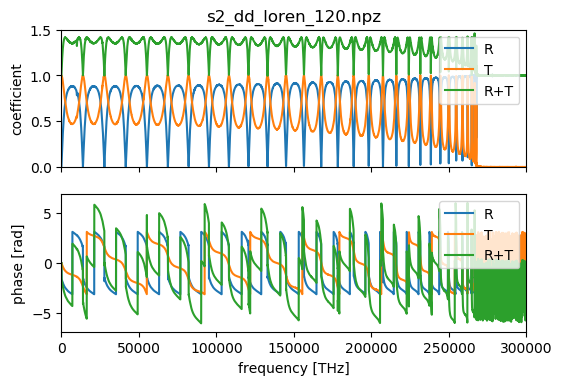

In [22]:
xmin = 0
xmax = 3e5
dpi = 100

for fname in sim_names:
    # Extract current name
    sim_file = Path(fname)
    # Only proceed if simulation files exist
    if sim_file.is_file():
        # Load results
        # ------------
        dat = np.load(fname)
        n = dat['n']
        ls = dat['ls']
        els = dat['els']
        erls = dat['erls']
        hls = dat['hls']
        hrls = dat['hrls']
        chi = dat['chi']
        # Plot fields in time
        # -------------------
        # Extract fields in time
        inc, trans, refl = calc_fields(els, erls)
        # Calculate offsets
        rofst = np.max(np.abs(np.real([inc, trans, refl])))
        iofst = np.max(np.abs(np.imag([inc, trans, refl])))
        # Plot
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        ax0.plot(n, np.real(inc)+rofst, label='$\Re(E_i(t))$')
        ax0.plot(n, np.real(trans), label='$\Re(E_t(t))$')
        ax0.plot(n, np.real(refl)-rofst, label='$\Re(E_r(t))$')
        ax1.plot(n, np.imag(inc)+iofst, label='$\Im(E_i(t))$')
        ax1.plot(n, np.imag(trans), label='$\Im(E_t(t))$')
        ax1.plot(n, np.imag(refl)-iofst, label='$\Im(E_r(t))$')
        ax0.set_title(fname)
        ax0.legend(loc=1)
        ax1.legend(loc=1)
        ax1.set_xlabel('time [ps]')
        plt.gcf().set_dpi(dpi)
        plt.show()
        # Plot FFT results
        # ----------------
        # Calculate FFT
        nf, incf, transf, reflf = calc_transforms(nlen, dn, inc, trans, refl)
        # Plot
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        ax0.plot(nf, np.absolute(incf), label='$E_i(\omega)$')
        ax0.plot(nf, np.absolute(transf), label='$E_t(\omega)$')
        ax0.plot(nf, np.absolute(reflf), label='$E_r(\omega)$')
        ax0.legend(loc=1)
        ax0.set_title(fname)
        ax0.set_ylabel('magnitude [?]')
        ax1.plot(nf, np.angle(incf), label='$E_i(\omega)$')
        ax1.plot(nf, np.angle(transf), label='$E_t(\omega)$')
        ax1.plot(nf, np.angle(reflf), label='$E_r(\omega)$')
        ax1.legend(loc=1)
        ax1.set_ylabel('phase [rad]')
        plt.xlabel('frequency [THz]')
        plt.xlim(xmin, xmax)
        plt.gcf().set_dpi(dpi)
        plt.show()
        # Plot Coefficients
        # -----------------
        # Coefficient Plot
        R = np.divide(reflf, incf)
        T = np.divide(transf, incf)
        # Plot
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        ax0.plot(nf, np.absolute(R), label='R')
        ax0.plot(nf, np.absolute(T), label='T')
        ax0.plot(nf, np.absolute(R)+np.absolute(T), label='R+T')
        ax0.legend(loc=1)
        ax0.set_title(fname)
        ax0.set_ylabel('coefficient')
        ax0.set_ylim(0, 1.5)
        ax1.plot(nf, np.angle(R), label='R')
        ax1.plot(nf, np.angle(T), label='T')
        ax1.plot(nf, np.angle(R)+np.angle(T), label='R+T')
        ax1.legend(loc=1)
        ax1.set_ylabel('phase [rad]')
        ax1.set_xlabel('frequency [THz]')
        plt.xlim(xmin, xmax)
        plt.gcf().set_dpi(dpi)
        plt.savefig('bleop.pdf', format='pdf')
        plt.show()